In [2]:
import sys
sys.path.append("..")   # this allows us to import from sibling directory

import matplotlib.pyplot as plt  
from sklearn.metrics import plot_confusion_matrix
from code_to_import.dataset_preprocessing import ProductionModeDataset

import torch
# from sklearn.inspection import permutation_importance
import numpy as np
import uproot
import torch.nn as nn
from matplotlib import pyplot as plt

from skorch import NeuralNetClassifier

from code_to_import.Classifier_module import Classifier
from code_to_import.Classifier_module import Three_Layer_Classifier
from code_to_import.Classifier_module import Two_Layer_Classifier
from torch.autograd import Variable


Using backend: pytorch


In [1]:
################# THIS IS WHERE YOU CHOOSE WHAT TO LOAD ################################

correlation_cut = -1   # if negative none, current other options are 0.9 and 0.8, but more can be added

cut_version = -1   # -1 means OG, otherwise can be 2 or 3 (or more if added)

event_type = "ee"  # could be ee, emu, mumu

weight_cmd = "true"   # could also be "false", "true" or "no-neg"

drop = 0.2  # drop rate

input_type = "allorentz_gen"

qg_cmd = False

batch_size = 7000


layer_number = "five"
layer_num_type = "more"

#This is only here in case format is changed... should be good for all three layer stuff otherwise
model_name = "GNN_Model4Layers_V1_" + event_type + "_corrCut_" + str(correlation_cut) + "_weights_" + weight_cmd + "_drop_" + str(drop)

if cut_version > 0:
    model_name += "cutV" + str(cut_version)

if input_type != "all":
    model_name += "_" + input_type
    
if not qg_cmd:
    model_name += "_no_qg"
    

model_name += "batch" + str(batch_size)

In [14]:
model_name

'twoLayerModel_ee_corrCut_-1.0_weights_true_drop_0.5_top_mttbar_reco_no_qg'

In [15]:

    
# root_path = "/depot-new/cms/top/mcnama20/TopSpinCorr-Run2-Entanglement/CMSSW_10_2_22/src/TopAnalysis/Configuration/analysis/diLeptonic/three_files/Nominal"

# file = root_path + "/" + event_type + "_modified_root_1_spinCorr.root"

path_to_model = "../models/" + layer_number + "_layers/" + model_name + ".pt"

title = "confusion_plot_" + model_name

In [16]:
############### Create a production mode dataset object and get the validation dataset.############################
################## NOTE: THIS NEEDS TO BE REPLACED BY LOADING THE SAVED DATASET FOR MODEL #########################
# data_object = ProductionModeDataset(file)
# x = data_object.get_eval_data()

x = np.load("../data/" + layer_number + "_layers/train_val_datasets/validation_dataset_" + model_name + ".npy")


In [17]:
############ remove parts of dataset not used in nn input and get output goals (target) and weights ####################
l = x.shape[1]   # get the initial length of the validation dataset
weight = x[:,l-2]   # get an array of weights for plotting
target = x[:,l-3]   # get targets
target = Variable(torch.from_numpy(target).type(torch.LongTensor))   # reformate target into a tensor

######################### remove excess inputs from x and call new variable y
y = np.transpose(x)   
y = np.delete(y, [l-3, l-2, l-1], 0)
y = np.transpose(y)

# the final validation input is gotten from turning y into a tensor
input = Variable(torch.from_numpy(y).type(torch.Tensor))

In [51]:
input.shape   # print to check stuff

torch.Size([20105, 8])

In [9]:
target

tensor([1, 0, 1,  ..., 1, 0, 0])

In [18]:
target.shape

torch.Size([20105])

In [19]:
qq = 0
for mode in target:
    if mode == 1:
        qq += 1

qq

10085

In [20]:
10085*2

20170

In [53]:
############################## Load the model and run eval so we know to evaluate ##################################
# try:
#     model = Classifier()
#     model.load_state_dict(torch.load(path_to_model))
# except:
if layer_number == "three":
    if not qg_cmd:
        model = Three_Layer_Classifier(input_size=input.shape[1], number_of_classes=2)
    else: 
        model = Three_Layer_Classifier(input_size=input.shape[1])
    model.load_state_dict(torch.load(path_to_model))
elif layer_number == "two":
    if not qg_cmd:
        model = Two_Layer_Classifier(input_size=input.shape[1], number_of_classes=2)
    else: 
        model = Two_Layer_Classifier(input_size=input.shape[1])
    model.load_state_dict(torch.load(path_to_model))
model.eval()

Two_Layer_Classifier(
  (model): Sequential(
    (0): Linear(in_features=8, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.0, inplace=False)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=2, bias=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
  )
)

In [54]:
########################### wrap the model into a skorch network so that sklearn functions can be used####################
nn = NeuralNetClassifier(model, max_epochs=0, lr=0.00, batch_size=5000)
nn.initialize()

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Two_Layer_Classifier(
    (model): Sequential(
      (0): Linear(in_features=8, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.0, inplace=False)
      (3): LeakyReLU(negative_slope=0.2, inplace=True)
      (4): Linear(in_features=256, out_features=2, bias=True)
      (5): LeakyReLU(negative_slope=0.2, inplace=True)
    )
  ),
)

In [55]:
# nn.score(input, target, sample_weight = weight)

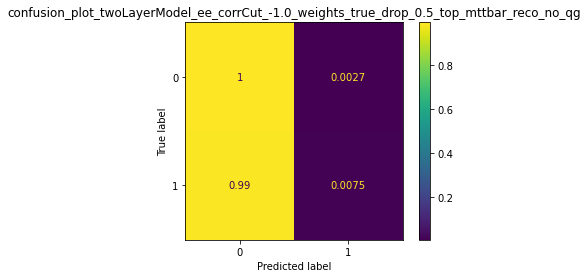

In [56]:
plot_confusion_matrix(nn,input, target,sample_weight = weight, normalize='true')  # create confusion matrix
plt.title(title)
plt.show()  # show confusion matrix

# if save:
#     # if save is true, then save the figure
#     plt.savefig('./results/' + title + '.pdf')